## Перевірка статистичних гіпотез:
### Гіпотеза однорідності (критерій пустих блоків),
### гіпотеза незалежності (критерії Спірмена та Кендалла) та
### гіпотеза випадковості (критерій, що ґрунтується на кількості інверсій)

Всі розрахунки проводяться при рівні значимості $ \gamma = 0.05 $.

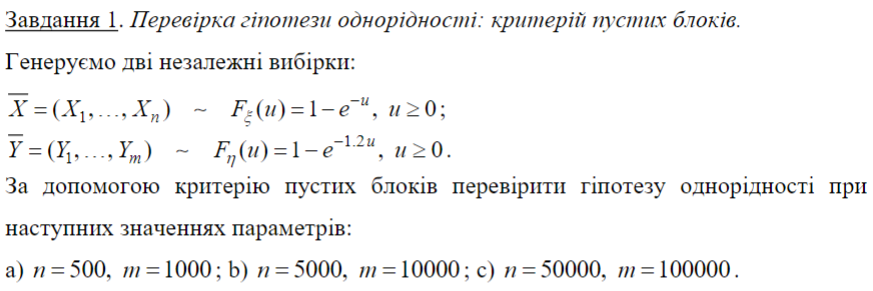

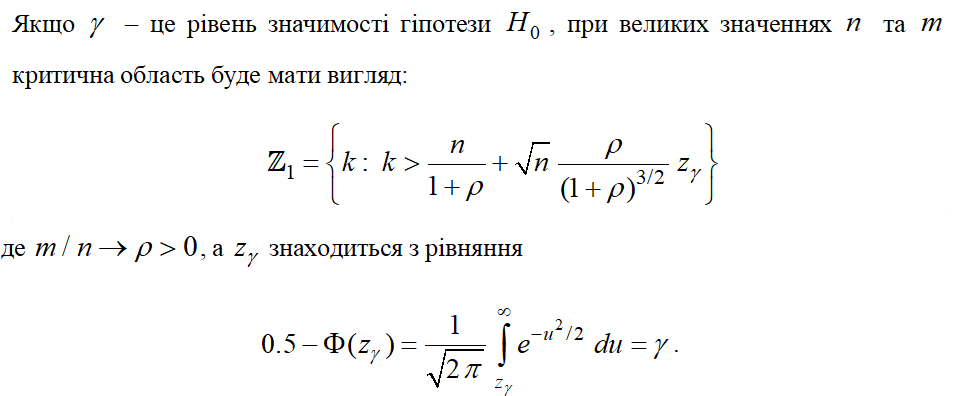

In [53]:
import numpy as np
from scipy.stats import norm

def empty_blocks_test(n, m, gamma=0.05):

    # Генеруємо вибірки
    X = np.random.exponential(scale=1.0, size=n)         # F_xi ~ Exp(1)
    Y = np.random.exponential(scale=1/1.2, size=m)       # F_eta ~ Exp(1.2)

    # Варіаційний ряд вибірки X
    R = np.sort(X)

    # Підрахунок порожніх блоків
    k = 0
    for i in range(n - 1):
        if not np.any((R[i] <= Y) & (Y <= R[i+1])):
            k += 1

    # Параметри критерію
    rho = m / n
    z_gamma = norm.ppf(1 - gamma / 2)
    critical_value = (n / (1 + rho)) + (np.sqrt(n) * rho * z_gamma) / ((1 + rho) ** 1.5)

    # Вивід результатів
    print(f"n = {n}, m = {m}, gamma = {gamma}")
    print(f"  Кількість порожніх блоків k       = {k}")
    print(f"  Критичне значення a_критичне      = {critical_value:.2f}")

    if k > critical_value:
        print("  Висновок: розподіли відрізняються ⇒ відхиляємо H₀.\n")
    else:
        print("  Висновок: розподіли однакові ⇒ приймаємо H₀.\n")

empty_blocks_test(n=500, m=1000)
empty_blocks_test(n=5000, m=10000)
empty_blocks_test(n=50000, m=100000)

n = 500, m = 1000, gamma = 0.05
  Кількість порожніх блоків k       = 169
  Критичне значення a_критичне      = 183.54
  Висновок: розподіли однакові ⇒ приймаємо H₀.

n = 5000, m = 10000, gamma = 0.05
  Кількість порожніх блоків k       = 1665
  Критичне значення a_критичне      = 1720.01
  Висновок: розподіли однакові ⇒ приймаємо H₀.

n = 50000, m = 100000, gamma = 0.05
  Кількість порожніх блоків k       = 17075
  Критичне значення a_критичне      = 16835.35
  Висновок: розподіли відрізняються ⇒ відхиляємо H₀.



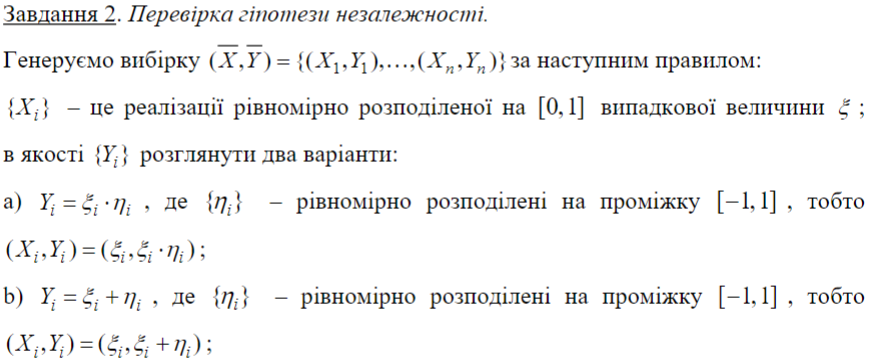

## А. Критерій Спірмена.
Перевірити гіпотезу незалежності за допомогою критерія Спірмена при наступних
значеннях параметра $n$:

а) $n = 500$ ; b) $n=5000$ ; с) $n=50000$.


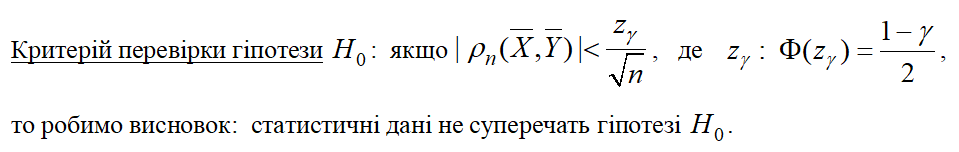

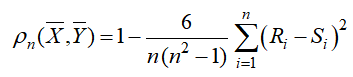

In [ ]:
import numpy as np
from scipy.stats import norm

def spearman_rank_correlation(x, y):
    """
    Обчислює рангову кореляцію Спірмена між векторами x і y.
    """
    n = len(x)
    rank_x = np.argsort(np.argsort(x)) + 1
    rank_y = np.argsort(np.argsort(y)) + 1
    rho = 1 - (6 * np.sum((rank_x - rank_y)**2)) / (n * (n**2 - 1))
    return rho

def spearman_test(x, y, gamma=0.05):
    """
    Перевіряє гіпотезу незалежності X і Y за допомогою статистики Спірмена.
    """
    n = len(x)
    rho = spearman_rank_correlation(x, y)
    z_gamma = norm.ppf(1 - gamma / 2)
    crit = z_gamma / np.sqrt(n)
    conclusion = "Залежні" if abs(rho) > crit else "Незалежні"
    return rho, crit, conclusion

gamma = 0.05
n_values = [500, 5000, 50000]

print(f"{'n':^10} {'Spearman Stat':^15} {'Spearman Crit':^15} {'Spearman Conclusion':^25} {'Type':^10}")
print("=" * 75)

# Варіант а): y = x * eta
for n in n_values:
    x = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)
    y = x * eta

    stat, crit, conclusion = spearman_test(x, y, gamma)
    print(f"{n:^10} {abs(stat):^15.3f} {crit:^15.3f} {conclusion:^25} {'a)':^10}")

print()

# Варіант б): y = x + eta
for n in n_values:
    x = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)
    y = x + eta

    stat, crit, conclusion = spearman_test(x, y, gamma)
    print(f"{n:^10} {abs(stat):^15.3f} {crit:^15.3f} {conclusion:^25} {'b)':^10}")

print("=" * 75)

    n       Spearman Stat   Spearman Crit     Spearman Conclusion       Type   
   500          0.083           0.088              Незалежні             a)    
   5000         0.026           0.028              Незалежні             a)    
  50000         0.005           0.009              Незалежні             a)    

   500          0.416           0.088               Залежні              b)    
   5000         0.430           0.028               Залежні              b)    
  50000         0.429           0.009               Залежні              b)    


## B. Критерій Кендалла.
Перевірити гіпотезу незалежності за допомогою критерія Кендалла при наступних
значеннях параметра $n$:

а) $n = 500$ ; b) $n=5000$ ; с) $n=50000$.

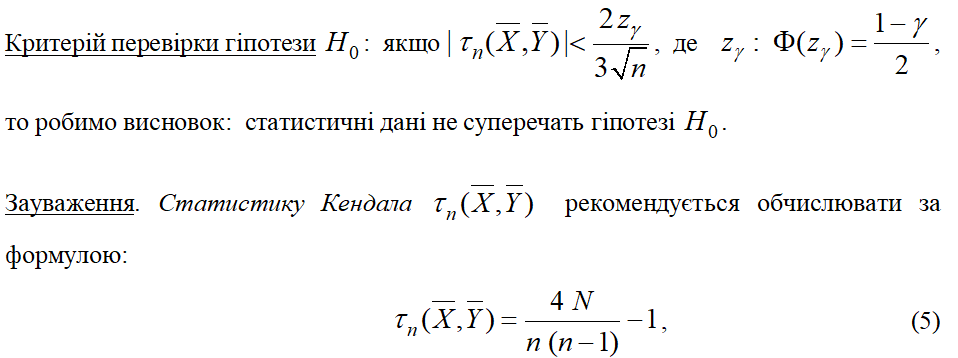

In [65]:
import numpy as np
import numba
from scipy.stats import norm

@numba.njit
def kendall_tau(x, y):
    """
    Обчислює τ_n(X, Y) за класичною формулою Кендалла:
    τ_n = (4N / (n(n - 1))) - 1,
    де N — кількість пар (i < j), для яких V_i < V_j,
    а V — ранги Y після сортування пар (X, Y) за X.
    """
    n = len(x)
    
    # Сортуємо пари (x, y) за x
    pairs = [(x[i], y[i]) for i in range(n)]
    pairs.sort(key=lambda pair: pair[0])
    V = [p[1] for p in pairs]
    
    # Рахуємо кількість пар з V[i] < V[j], i < j
    N = 0
    for i in range(n):
        for j in range(i + 1, n):
            if V[i] < V[j]:
                N += 1
    
    tau_n = (4 * N) / (n * (n - 1)) - 1
    return tau_n

def kendall_independence_test(x, y, gamma=0.05):
    """
    Тестує гіпотезу незалежності H0: X ⊥ Y
    за допомогою критерію Кендалла:
    |tau_n| < 2z_gamma / (3√n) — не відхиляємо H0
    """
    n = len(x)
    tau_n = kendall_tau(x, y)
    tau_n_abs = abs(tau_n)
    
    z_gamma = norm.ppf(1 - gamma / 2)
    threshold = 2 * z_gamma / (3 * np.sqrt(n))
    
    conclusion = "Незалежні" if tau_n_abs < threshold else "Залежні"
    
    return tau_n_abs, threshold, conclusion

gamma = 0.05
n_values = [500, 5000, 50000]

print(f"{'n':^10} {'Kendall Tau':^15} {'Kendall Crit':^15} {'Висновок':^20} {'Type':^8}")
print("=" * 70)

# Варіант (a): y = x * eta
for n in n_values:
    x = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)
    y = x * eta
    
    tau_abs, crit, conclusion = kendall_independence_test(x, y, gamma)
    print(f"{n:^10} {tau_abs:^15.3f} {crit:^15.3f} {conclusion:^20} {'a)':^8}")

print()

# Варіант (b): y = x + eta
for n in n_values:
    x = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)
    y = x + eta
    
    tau_abs, crit, conclusion = kendall_independence_test(x, y, gamma)
    print(f"{n:^10} {tau_abs:^15.3f} {crit:^15.3f} {conclusion:^20} {'b)':^8}")
    
print("=" * 70)

    n        Kendall Tau    Kendall Crit         Висновок         Type  
   500          0.016           0.058           Незалежні          a)   
   5000         0.001           0.018           Незалежні          a)   
  50000         0.005           0.006           Незалежні          a)   

   500          0.321           0.058            Залежні           b)   
   5000         0.279           0.018            Залежні           b)   
  50000         0.293           0.006            Залежні           b)   


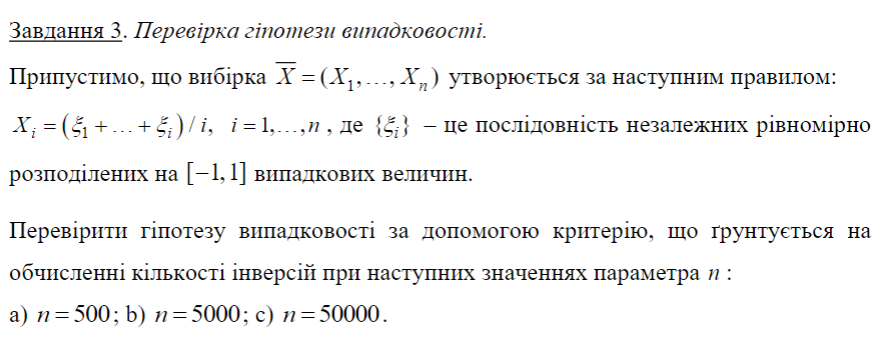

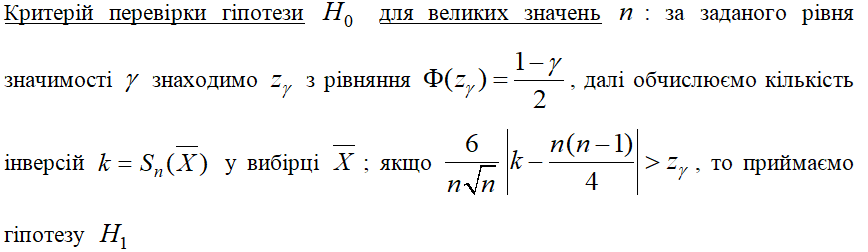

In [20]:
import numpy as np
from scipy.stats import norm
from numba import njit

def generate_sample(n):
    """Генерує вибірку X згідно з заданим правилом."""
    xi = np.random.uniform(-1, 1, size=(n))
    cumulative_sums = np.cumsum(xi)/np.arange(1, n +1)
    return cumulative_sums

@njit
def count_inversions(arr):
    """Підраховує кількість інверсій у масиві."""
    count = 0
    for i in range(len(arr)):
        for j in range(i + 1, len(arr)):
            if arr[i] > arr[j]:
                count += 1
    return count

def test_randomness(n, gamma=0.05):
    """Перевіряє гіпотезу випадковості для вибірки розміру n."""
    sample = generate_sample(n)
    k = count_inversions(sample)

    # Знаходимо z_gamma
    z_gamma = norm.ppf(1 - gamma / 2)
    expected_inversions = n * (n - 1) / 4
    # Обчислюємо статистику критерію
    statistic = 6 / (n * np.sqrt(n)) *abs( k - (n * (n - 1)) / 4)

    print(f"n = {n}, gamma = {gamma}:")
    print(f"  Кількість інверсій: {k}")
    print(f"  Очікувана кількість інверсій: {expected_inversions}")
    print(f"  z_gamma: {z_gamma}")
    print(f"  Статистика критерію: {statistic}")

    # Перевірка гіпотези
    if statistic > z_gamma:
        print("  Нульова гіпотеза відхиляється: вибірка не є випадковою.")
    else:
        print("  Нульова гіпотеза приймається: вибірка є випадковою.")

# Перевірка для різних значень n
test_randomness(500)
print()
test_randomness(5000)
print()
test_randomness(50000)

n = 500, gamma = 0.05:
  Кількість інверсій: 54277
  Очікувана кількість інверсій: 62375.0
  z_gamma: 1.959963984540054
  Статистика критерію: 4.345842835630392
  Нульова гіпотеза відхиляється: вибірка не є випадковою.

n = 5000, gamma = 0.05:
  Кількість інверсій: 4192528
  Очікувана кількість інверсій: 6248750.0
  z_gamma: 1.959963984540054
  Статистика критерію: 34.89524447579916
  Нульова гіпотеза відхиляється: вибірка не є випадковою.

n = 50000, gamma = 0.05:
  Кількість інверсій: 464309778
  Очікувана кількість інверсій: 624987500.0
  z_gamma: 1.959963984540054
  Статистика критерію: 86.22871412683523
  Нульова гіпотеза відхиляється: вибірка не є випадковою.
